In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image
import numbergen as ng
import imagen as ig
from skimage.transform import resize
import time
import cv2
from ssn.random_pattern import random_pattern
import numbergen as ng
import imagen as ig
import random
import imageio
from evaluation import evaluate, mitsuba_render,net_gt, net_render

options:  Namespace(file='/home/ysheng/.local/share/jupyter/runtime/kernel-172f6875-8cb7-4261-b455-51258af6f4e0.json', ibl=None, mask=None, output=None, verbose=False, weight='../weights/new_pattern_09-May-12-07-AM.pt')
Device:  cpu


In [3]:
pattern_generator = random_pattern()

In [4]:
def show(img, title='',cmap=None): 
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [66]:
testing_ibl_folder = '/home/ysheng/Dataset/ibls/pattern/'
high_reso_testing_ibl_folder = '/home/ysheng/Dataset/ibls/high_pattern/'
testing_real_ibl_folder = '/home/ysheng/Dataset/ibls/real/'
model_folder = '/home/ysheng/Dataset/models/'
result_folder = '/home/ysheng/Dataset/evaluation'

os.makedirs(result_folder, exist_ok=True)


In [49]:
sample_dimension = 10
num_list = [i for i in range(1, 52, 2)]
size_list = [i * 0.01 for i in range(1,11)]

print(num_list)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]


In [7]:
def normalize(ibl, energy=3500):
    total_energy = np.sum(ibl)
    if total_energy < 1e-3:
        print('small energy: ', total_energy)
        return np.zeros((80,512))

    ibl = ibl * energy / total_energy

    return ibl

def to_normalized_ibl(ibl):
    """ input is pattern generated ibl [80x512]
        output is noramlized ibl: [16x32]
    """
    ibl = cv2.resize(ibl, (32, 5))
    ret = np.zeros((16, 32))
    ret[:5,:] = ibl
    return ret

def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

In [8]:
model_lists = get_files(model_folder)
test_model_list = []
for m in model_lists:
    model_name = os.path.splitext(os.path.basename(m))[0]
    test_model_list.append(model_name)

random.seed(19920208)
test_model_list = random.sample(test_model_list, k=10, )
print(len(test_model_list))
print(len(set(test_model_list)))

10
10


## prepare mask input

In [9]:
mask_dict = dict()
mask_root = '/home/ysheng/Dataset/new_dataset/cache/mask/'
for model in test_model_list:
    mask_folder = join(mask_root, model)
    masks = get_files(mask_folder)
    filterd_masks = []
    for m in masks:
        if m.find('.png') != -1:
            filterd_masks.append(m)
    
    mask_dict[model] = filterd_masks

## prepare testing ibls

In [ ]:
scale = 3.0
os.makedirs(testing_ibl_folder, exist_ok=True)
os.makedirs(high_reso_testing_ibl_folder, exist_ok=True)

for num in tqdm(num_list):
    for size in size_list:
        seed = random.randint(0,19920208)
        factor = 80/256
        if num == 0:
            ibl = np.zeros((80,512))
        else:
            # 80 x 512
            ibl = pattern_generator.get_pattern(num, size=size)
        
        title = 'num_{}_size_{}_ibl.png'.format(num, size)
        
        plt.imsave(os.path.join(high_reso_testing_ibl_folder, title),ibl, cmap='gray')
#         show(ibl)
        
        # to 16 x 32
        ibl = cv2.normalize(cv2.resize(ibl, (32, 16)), 0.0, 1.0, cv2.NORM_MINMAX) 
#         show(ibl, title)
        plt.imsave(os.path.join(testing_ibl_folder, title),ibl,cmap='gray')

  4%|▍         | 1/26 [00:00<00:03,  8.26it/s]

small energy:  0.00011416507514290522
small energy:  0.0007547894105509711


 46%|████▌     | 12/26 [00:10<00:18,  1.30s/it]

## prepare real testing ibls 

  0%|          | 0/14 [00:00<?, ?it/s]

14 real ibls


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


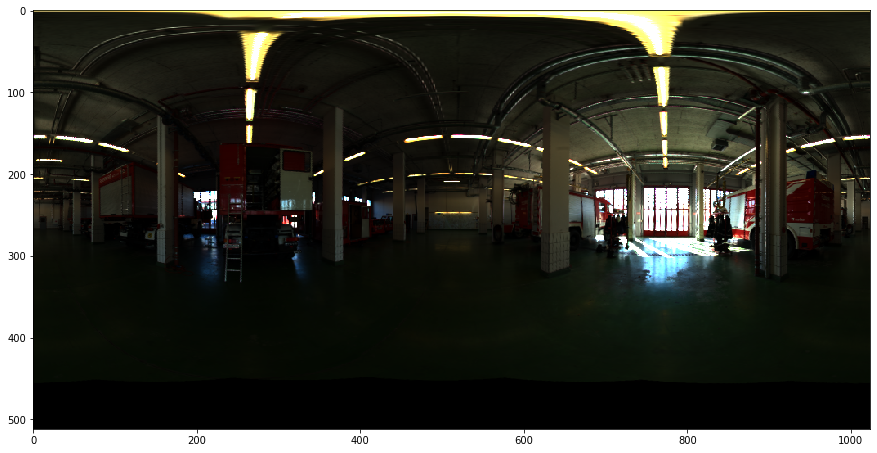

  7%|▋         | 1/14 [00:00<00:11,  1.17it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


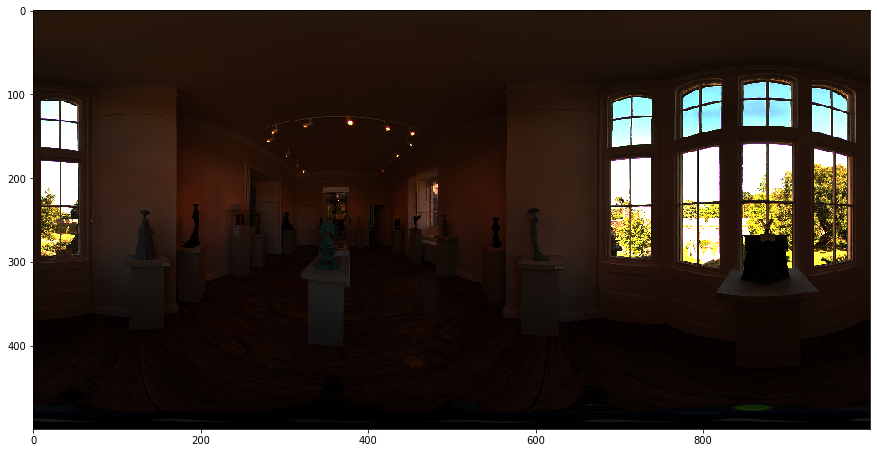

 14%|█▍        | 2/14 [00:01<00:09,  1.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


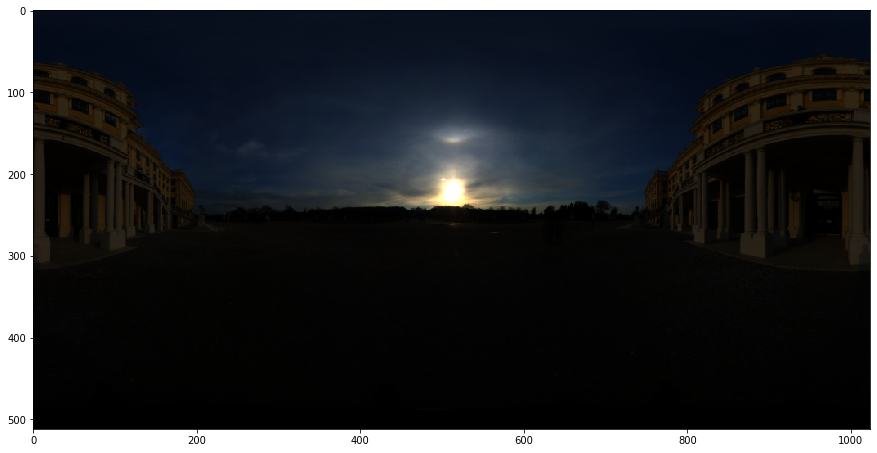

 21%|██▏       | 3/14 [00:02<00:08,  1.33it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


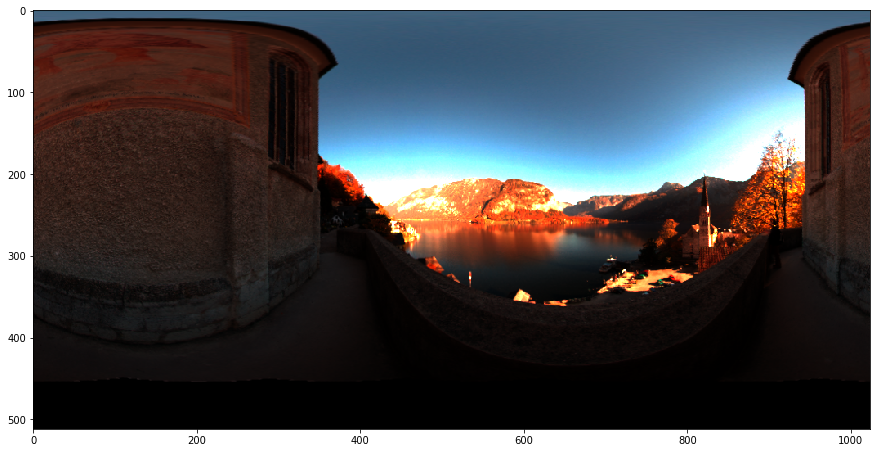

 29%|██▊       | 4/14 [00:02<00:07,  1.41it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


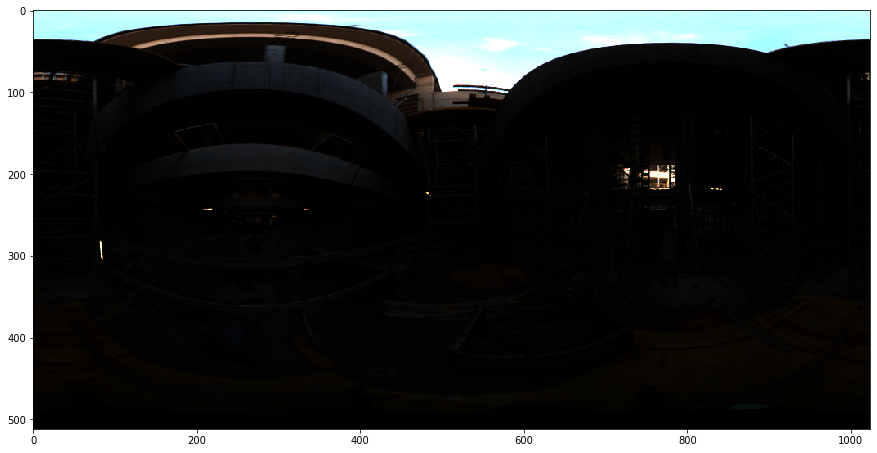

 36%|███▌      | 5/14 [00:03<00:05,  1.58it/s]

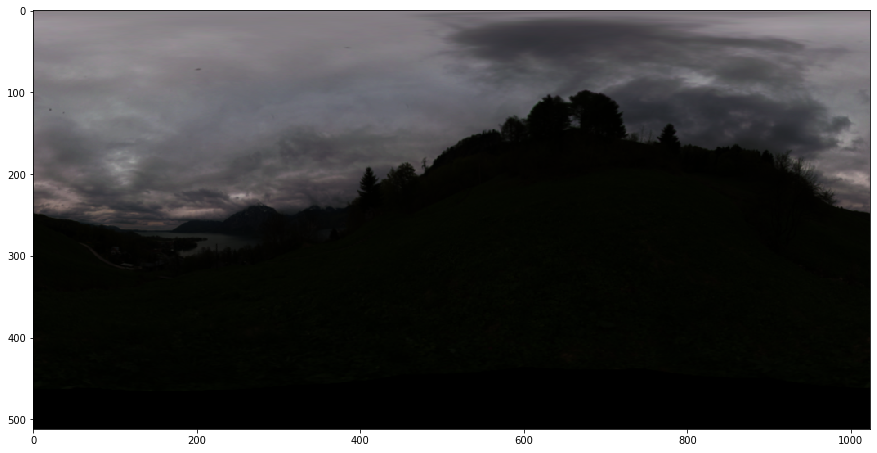

 43%|████▎     | 6/14 [00:03<00:04,  1.63it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


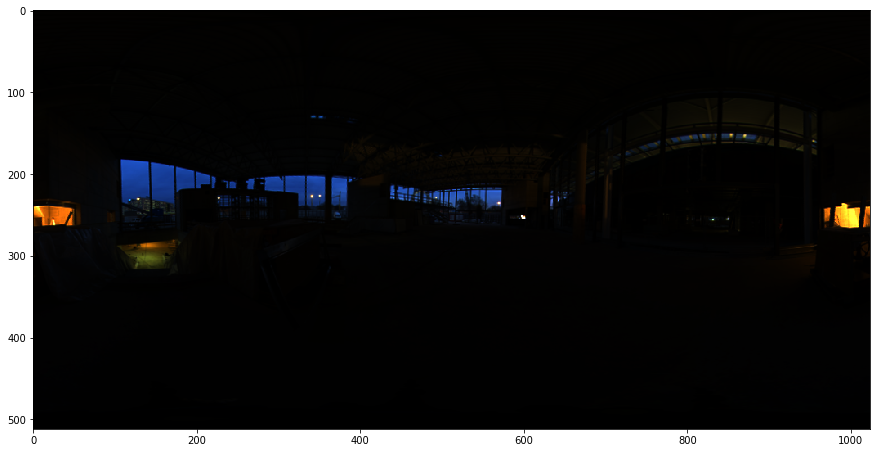

 50%|█████     | 7/14 [00:04<00:04,  1.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


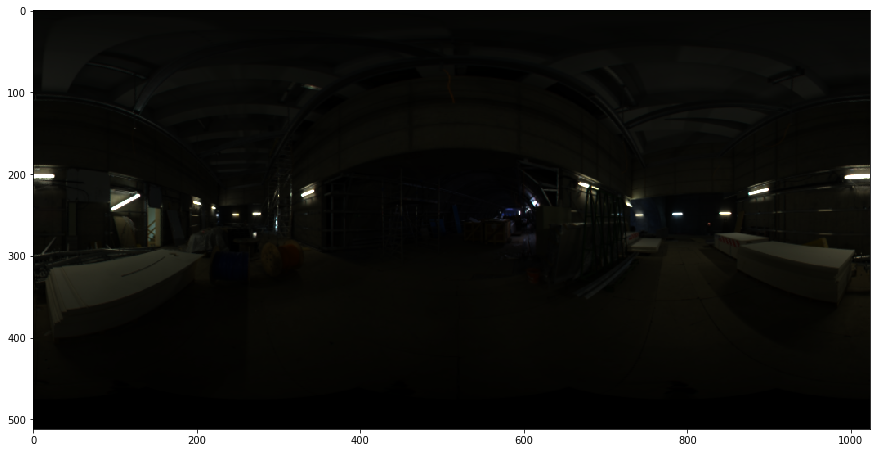

 57%|█████▋    | 8/14 [00:04<00:03,  1.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


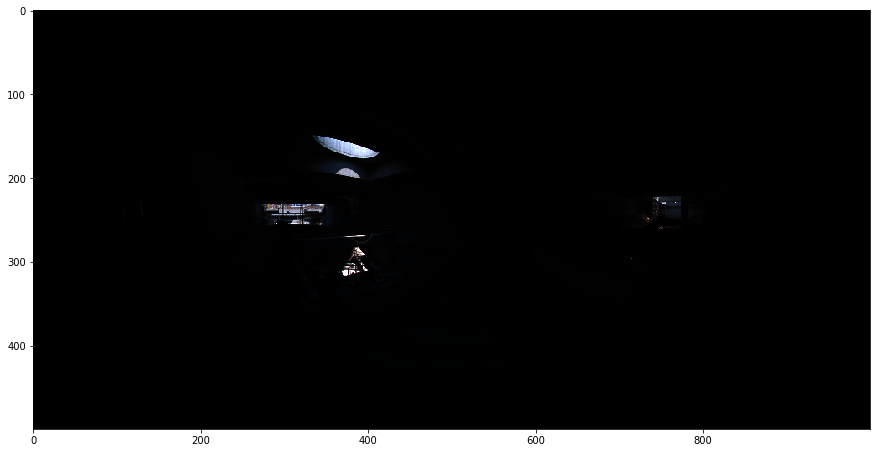

 64%|██████▍   | 9/14 [00:05<00:02,  1.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


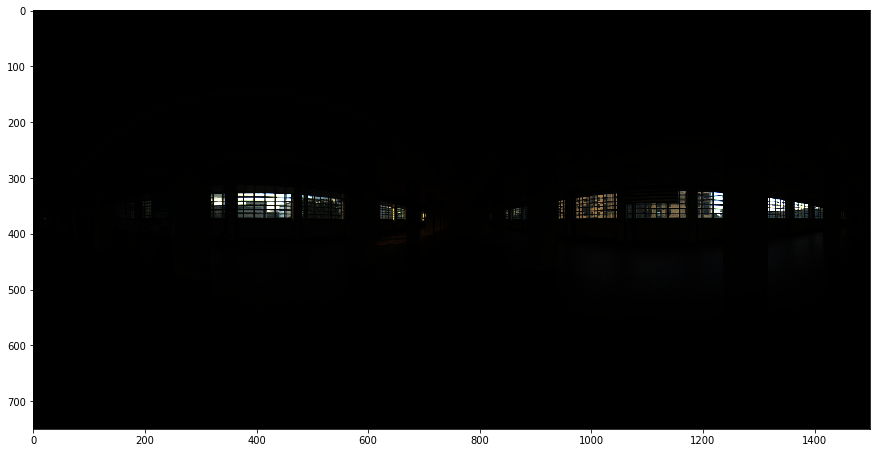

 71%|███████▏  | 10/14 [00:06<00:02,  1.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


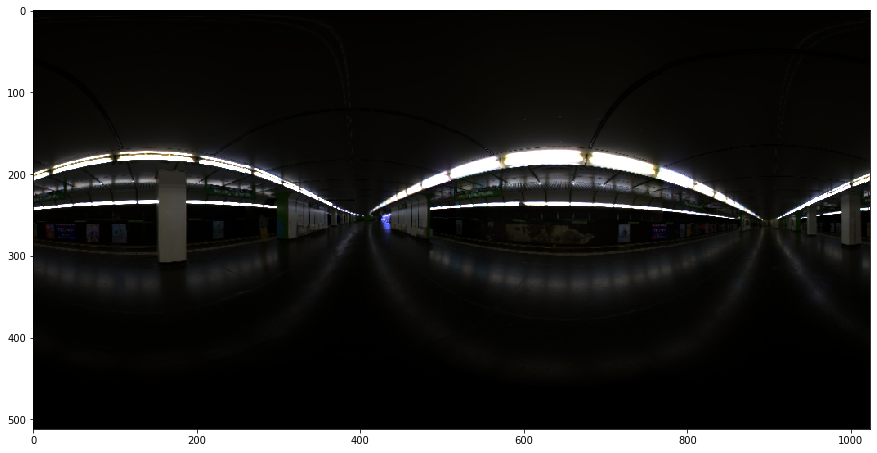

 79%|███████▊  | 11/14 [00:06<00:01,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


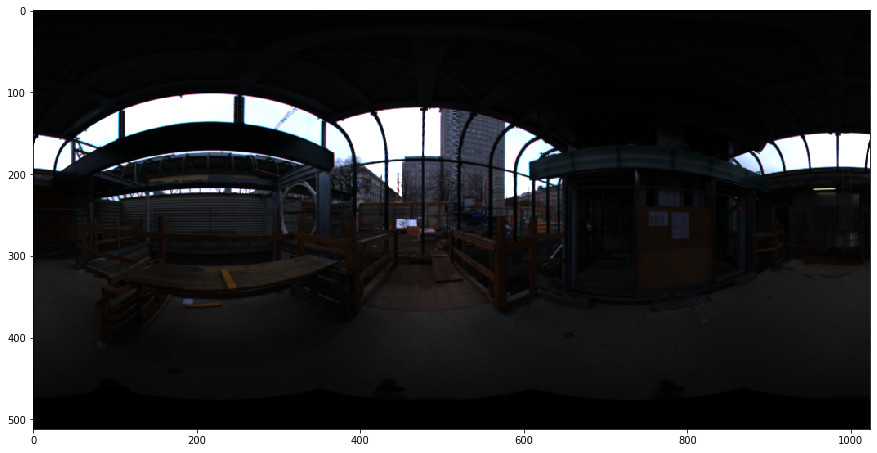

 86%|████████▌ | 12/14 [00:07<00:01,  1.67it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


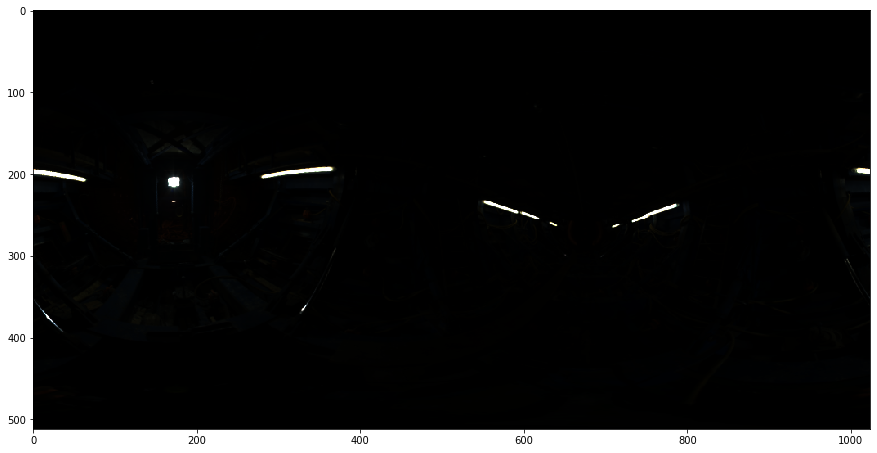

 93%|█████████▎| 13/14 [00:07<00:00,  1.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


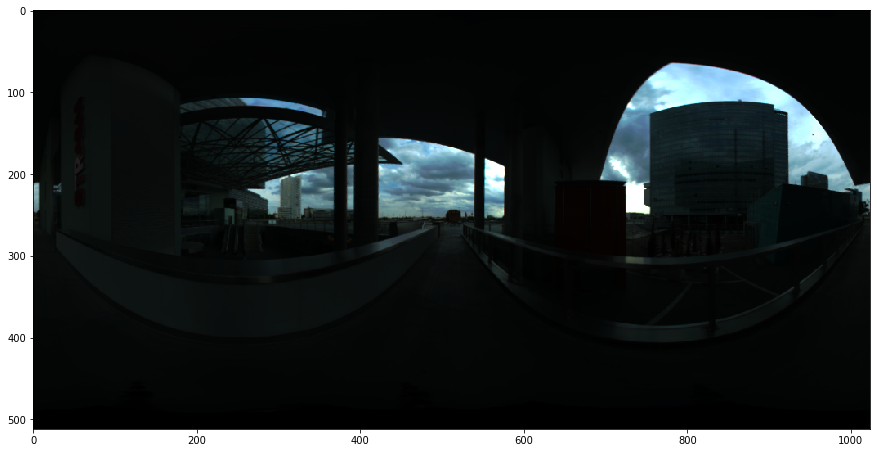

100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


In [14]:
hdr_ibl_folder = join('/home/ysheng/Dataset/ibls/real/', 'hdr')

files = get_files(hdr_ibl_folder)
print('{} real ibls'.format(len(files)))

for f in tqdm(files):
    hdr_img = imageio.imread(f)
    show(hdr_img)
    hdr_img = cv2.resize(hdr_img, (32,16))
    fname = os.path.basename(f)
    hdr_img[6:,:] = 0.0
    cur_save_path = join(testing_real_ibl_folder, fname)
    imageio.imwrite(cur_save_path, hdr_img)

## prepare animation ibls

## output pattern batch data

In [56]:
""" (model, ibl) -> one scene
"""
ibl_files = get_files(testing_ibl_folder)
# random.seed(19920208)
# random.shuffle(ibl_files)
# ibl_files = ibl_files[:100]
real_ibl_files = get_files(testing_real_ibl_folder)

ibl_files += real_ibl_files
print(len(ibl_files))
print(ibl_files)

scene_dict={}
random.seed(19920208)
for model in test_model_list:
    for ibl_file in ibl_files:
        scene_dict[(model, ibl_file)] = random.sample(mask_dict[model], k=1)[0]

274
['/home/ysheng/Dataset/ibls/pattern/num_5_size_0.03_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_35_size_0.02_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_41_size_0.1_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_9_size_0.06_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_3_size_0.07_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_7_size_0.01_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_17_size_0.04_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_11_size_0.09_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_21_size_0.07_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_25_size_0.07_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_23_size_0.09_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_45_size_0.09_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_25_size_0.01_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_47_size_0.01_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_7_size_0.1_ibl.png', '/home/ysheng/Dataset/ibls/pattern/num_3_size_0.05_ibl.png', '/home/yshe

### Mitsuba script

In [59]:
total = len(test_model_list) * len(ibl_files)
counter = 0
bash_file = 'mitsuba_bash.sh'
if os.path.exists(bash_file):
    os.remove(bash_file)

with tqdm(total=total) as pbar:
    for model in test_model_list:
        for i, ibl_file in enumerate(ibl_files):
            output_folder = os.path.join(result_folder, model)
            os.makedirs(output_folder, exist_ok=True)
            
            if i < (len(ibl_files) - len(real_ibl_files)):
                cur_output = join(output_folder,'pattern')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = False
            else:
                cur_output = join(output_folder, 'real')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = True
            
            model_path = join(model_folder, model + ".obj")
            ibl_name = os.path.splitext(os.path.basename(ibl_file))[0]
            
            cur_output = join(cur_output, ibl_name)
            os.makedirs(cur_output, exist_ok=True)
            
            final_out_file, shadow_out_file = join(cur_output, 'mitsuba_final.exr'), join(cur_output, 'mitsuba_shadow.exr')

            mask_path = scene_dict[(model, ibl_file)]
            if model == 'simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH' and ibl_file == '/home/ysheng/Dataset/ibls/real/20050806-03_hd.hdr':
                print(mask_path)
                
            mitsuba_render(mask_path, ibl_file, final_out_file, shadow_out_file, real_ibl=real_ibl, write_cmd=True, skip=False)
            with open(bash_file, 'a+') as f:
                counter += 1
                f.write('echo finish: {}\n'.format(counter/total))
            pbar.update()

100%|██████████| 2740/2740 [00:04<00:00, 573.47it/s]

/home/ysheng/Dataset/new_dataset/cache/mask/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pitch_15_rot_270_mask.png


In [16]:
print(len(test_model_list))
print(len(set(test_model_list)))

print(len(ibl_files))
print(len(set(ibl_files)))

10
10
114
114


### Net predcitions

In [58]:
import shutil 
# ibl_files, model_list
total = len(test_model_list) * len(ibl_files)
counter = 0
with tqdm(total=total) as pbar:
    for model in test_model_list:
        for i,ibl_file in enumerate(ibl_files):
            output_folder = os.path.join(result_folder, model)
            os.makedirs(output_folder, exist_ok=True)
            
            if i < (len(ibl_files) - len(real_ibl_files)):
                cur_output = join(output_folder,'pattern')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = False
            else:
                cur_output = join(output_folder, 'real')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = True
            
            model_path = join(model_folder,join(model, model + ".obj"))
            ibl_name = os.path.splitext(os.path.basename(ibl_file))[0]
            
            cur_output = join(cur_output, ibl_name)
            os.makedirs(cur_output, exist_ok=True)
            
            mask_path = scene_dict[(model, ibl_file)]
            gt_out_file, predict_out_file = join(cur_output, 'gt.png'), join(cur_output, 'predict.png')
            
            shutil.copyfile(mask_path, join(cur_output, 'mask.png'))
            net_gt(mask_path, ibl_file, gt_out_file)
            net_render(mask_path, ibl_file, predict_out_file)
            pbar.update()

  0%|          | 0/2740 [00:00<?, ?it/s]


ValueError: shape-mismatch for sum

### Final processing
1. flip mitsuab shadow
2. composite my mitsuba shadow

In [40]:
def composite_shadow(mask_np, mitsuba_final_np, mitsuba_shadow_np):
    masked_area = np.where(mask_np > 1e-3)
    
    ret = np.copy(mitsuba_shadow_np)
    ret[masked_area] = mitsuba_final_np[masked_area]
    return ret

counter = 0
with tqdm(total=total) as pbar:
    for model in test_model_list:
        for i,ibl_file in enumerate(ibl_files):
            output_folder = os.path.join(result_folder, model)
            os.makedirs(output_folder, exist_ok=True)
            
            if i < (len(ibl_files) - len(real_ibl_files)):
                cur_output = join(output_folder,'pattern')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = False
            else:
                cur_output = join(output_folder, 'real')
                os.makedirs(cur_output, exist_ok=True)
                real_ibl = True
                
            ibl_name = os.path.splitext(os.path.basename(ibl_file))[0]
            cur_output = join(cur_output, ibl_name)
            
            mask_path = scene_dict[(model, ibl_file)]
            mitsuba_final, mitsuba_final_shadow = join(cur_output, 'mitsuba_final.png'), join(cur_output, 'mitsuba_shadow.png')
            
            if not os.path.exists(mitsuba_final) or not os.path.exists(mitsuba_final_shadow):
                print('{} or {} not exist, skip'.format(mitsuba_final, mitsuba_final_shadow))
                continue
                pbar.update()
                
#             mask_np = np.load(mask_path)
            mask_np = imageio.imread(join(cur_output, 'mask.png'))
            mask_np = mask_np[:,:,0]
            if mask_np.dtype == np.uint8:
                mask_np = mask_np/255.0
                
            mitsuba_final_np, mitsuba_final_shadow_np = imageio.imread(mitsuba_final), imageio.imread(mitsuba_final_shadow)
            if mitsuba_final_np.dtype==np.uint8:
                mitsuba_final_np = mitsuba_final_np/255.0
            # normalize final image
            cv2.normalize(mitsuba_final_np, mitsuba_final_np, 0.0, 1.0, cv2.NORM_MINMAX)
            
            # composite our shadow
            composite_np = composite_shadow(mask_np, mitsuba_final_np, mitsuba_final_shadow_np)
            imageio.imwrite(join(cur_output, 'composite.png'), composite_np)
            
            # filp shadow
            mistuba_flipped = 1.0 - mitsuba_final_shadow_np/255.0
            plt.imsave(join(cur_output, 'mitsuba_shaddow_flipped.png'),mistuba_flipped, cmap='gray')
            pbar.update()

  2%|▏         | 18/1140 [00:00<00:28, 39.30it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


  3%|▎         | 32/1140 [00:00<00:26, 41.18it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


  5%|▍         | 52/1140 [00:01<00:24, 44.84it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


  6%|▌         | 63/1140 [00:01<00:22, 47.84it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


  8%|▊         | 90/1140 [00:02<00:22, 45.92it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 11%|█         | 126/1140 [00:03<00:29, 34.67it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 12%|█▏        | 136/1140 [00:03<00:25, 38.73it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 14%|█▍        | 157/1140 [00:04<00:21, 45.22it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 15%|█▍        | 168/1140 [00:04<00:20, 47.96it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 17%|█▋        | 195/1140 [00:04<00:20, 46.63it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 20%|██        | 231/1140 [00:06<00:25, 35.03it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 21%|██        | 241/1140 [00:06<00:23, 38.51it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 23%|██▎       | 262/1140 [00:06<00:19, 45.38it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 24%|██▍       | 273/1140 [00:07<00:18, 47.78it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 26%|██▋       | 300/1140 [00:07<00:18, 46.15it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_A/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 30%|██▉       | 337/1140 [00:09<00:22, 35.99it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 30%|███       | 347/1140 [00:09<00:21, 37.40it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 32%|███▏      | 368/1140 [00:09<00:17, 45.22it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 33%|███▎      | 379/1140 [00:10<00:15, 48.47it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 36%|███▌      | 406/1140 [00:10<00:15, 48.56it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Walking_B/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 38%|███▊      | 438/1140 [00:11<00:21, 33.06it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 40%|███▉      | 453/1140 [00:12<00:16, 40.81it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 41%|████▏     | 473/1140 [00:12<00:15, 44.15it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 42%|████▏     | 484/1140 [00:12<00:14, 46.42it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 45%|████▍     | 511/1140 [00:13<00:13, 46.67it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Standing_C/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 48%|████▊     | 543/1140 [00:14<00:18, 31.80it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 49%|████▉     | 559/1140 [00:15<00:14, 40.16it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 51%|█████     | 580/1140 [00:15<00:12, 43.70it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 51%|█████▏    | 587/1140 [00:15<00:11, 47.08it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 54%|█████▍    | 615/1140 [00:16<00:11, 47.26it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 57%|█████▋    | 653/1140 [00:17<00:13, 35.96it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 58%|█████▊    | 663/1140 [00:17<00:12, 38.82it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 60%|██████    | 684/1140 [00:18<00:10, 44.38it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 61%|██████    | 691/1140 [00:18<00:09, 48.19it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 63%|██████▎   | 720/1140 [00:19<00:08, 48.32it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_sweateroutfitall_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 66%|██████▋   | 758/1140 [00:20<00:10, 36.18it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 67%|██████▋   | 768/1140 [00:20<00:09, 40.15it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 69%|██████▉   | 784/1140 [00:21<00:07, 44.71it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 70%|███████   | 801/1140 [00:21<00:07, 44.63it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 72%|███████▏  | 824/1140 [00:21<00:06, 48.74it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 76%|███████▌  | 861/1140 [00:23<00:08, 34.35it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 76%|███████▋  | 871/1140 [00:23<00:07, 38.34it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 78%|███████▊  | 892/1140 [00:23<00:05, 46.10it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 79%|███████▉  | 903/1140 [00:24<00:04, 49.34it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 82%|████████▏ | 931/1140 [00:24<00:04, 47.76it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Walking_A/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 84%|████████▍ | 963/1140 [00:25<00:05, 33.09it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_5_size_0.02_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_5_size_0.02_ibl/mitsuba_shadow.png not exist, skip


 86%|████████▌ | 979/1140 [00:26<00:03, 41.69it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_34_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_34_size_0.1_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_5_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_5_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 88%|████████▊ | 1000/1140 [00:26<00:03, 45.59it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_1_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_1_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_29_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_29_size_0.09_ibl/mitsuba_shadow.png not exist, skip


 88%|████████▊ | 1007/1140 [00:26<00:02, 48.45it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_0_size_0.09_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_0_size_0.09_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_16_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_16_size_0.01_ibl/mitsuba_shadow.png not exist, skip


 91%|█████████ | 1035/1140 [00:27<00:02, 47.25it/s]

/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_0_size_0.01_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_0_size_0.01_ibl/mitsuba_shadow.png not exist, skip
/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_20_size_0.1_ibl/mitsuba_final.png or /home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_20_size_0.1_ibl/mitsuba_shadow.png not exist, skip


 92%|█████████▏| 1050/1140 [00:28<00:02, 37.04it/s]


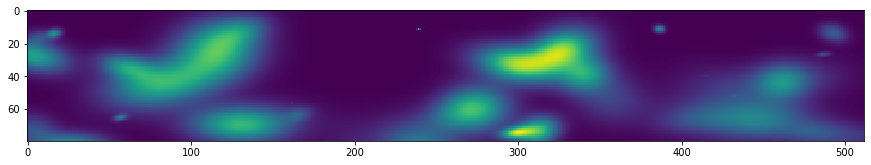

(80, 512)


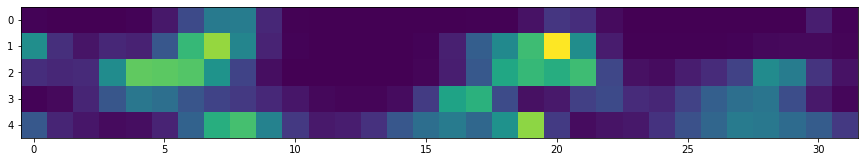

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


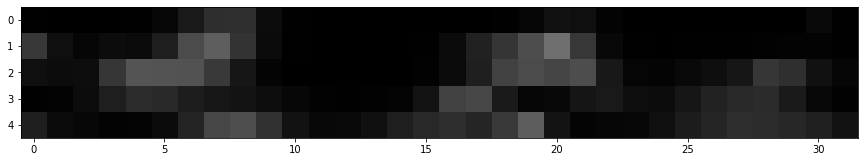

In [21]:
test_ibl = pattern_generator.get_pattern()
show(test_ibl)
test_ibl_file = 'test_ibl.png'
print(test_ibl.shape)
test_ibl = cv2.resize(test_ibl, (32,5))
show(test_ibl)
imageio.imwrite(test_ibl_file, test_ibl)

print()
test_ibl_read = imageio.imread(test_ibl_file)
show(test_ibl_read)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float32 1.265625


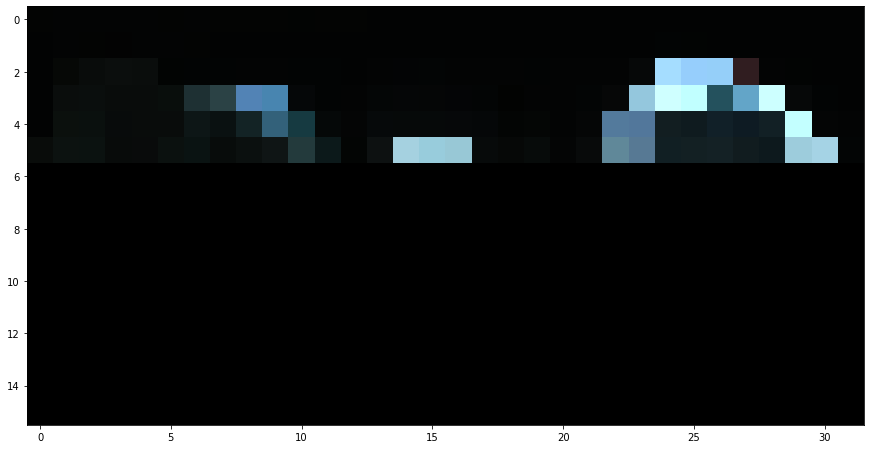

Lossy conversion from float32 to uint8. Range [0.0, 1.265625]. Convert image to uint8 prior to saving to suppress this warning.


uint8 255


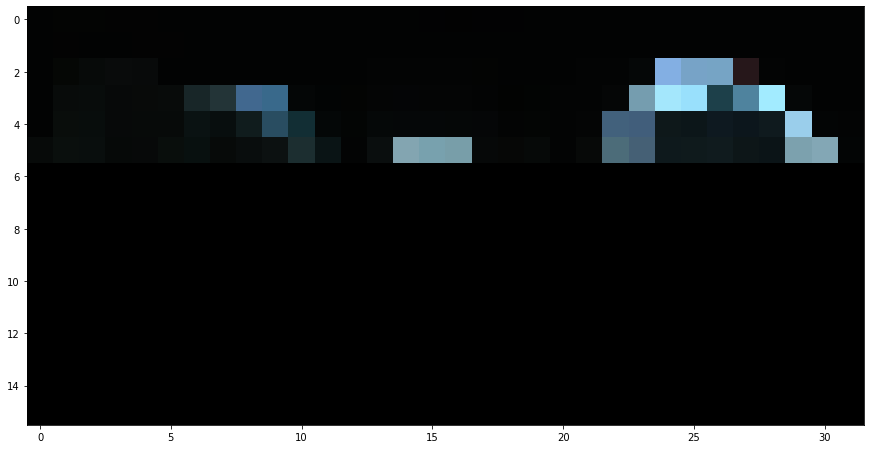

In [7]:
test_ibl = '/home/ysheng/Dataset/ibls/real/20050806-03_hd.hdr'
ibl = imageio.imread(test_ibl)
print(ibl.dtype, np.max(ibl))
show(ibl)

new_test = 'test.png'
imageio.imwrite(new_test, ibl)

ibl = imageio.imread(new_test)
print(ibl.dtype, np.max(ibl))
show(ibl)
# test_ibl = '/home/ysheng/Dataset/ibls/pattern/num_19_size_0.01_ibl.png'
# ibl = imageio.imread(test_ibl)
# print(np.max(ibl))

shape: (5, 32, 4) max: 1.0 sum: 172.0 factor: 465.1162790697674
1.0


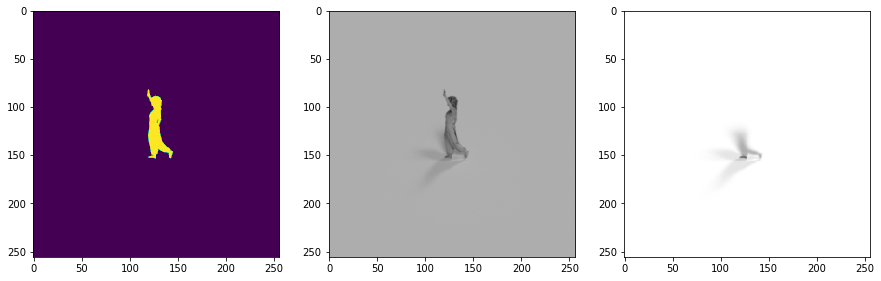

In [42]:
mask_file = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_48_size_0.07_ibl/mask.png'
mitsuba_final = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_48_size_0.07_ibl/mitsuba_final.png'
mitsuba_shadow = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_48_size_0.07_ibl/mitsuba_shadow.png'

ibl_file = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_48_size_0.07_ibl/ibl.png'
ibl_np = imageio.imread(ibl_file)
ibl_np = ibl_np/255.0
print('shape: {} max: {} sum: {} factor: {}'.format(ibl_np.shape, np.max(ibl_np), np.sum(ibl_np), 80000/ np.sum(ibl_np)))

# mask_np = np.load(mask_file)
mask_np = imageio.imread(mask_file)
mask_np = mask_np[:,:,0]/255.0
print(np.max(mask_np))

mitsuab_final_np = imageio.imread(mitsuba_final)
mitsuba_shadow_np = imageio.imread(mitsuba_shadow)

fig = plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(mask_np)

plt.subplot(1, 3, 2)
plt.imshow(mitsuab_final_np)

plt.subplot(1, 3, 3)
plt.imshow(mitsuba_shadow_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


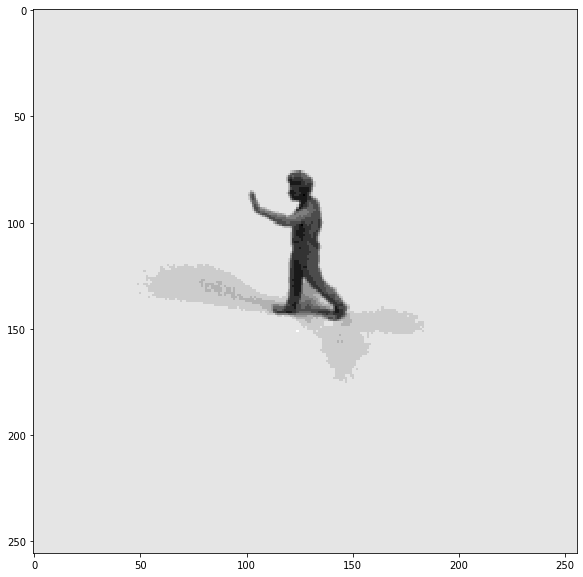

In [38]:
img_file = '/home/ysheng/Dataset/evaluation/simulated_combine_male_short_outfits_genesis8_armani_semicasual_Base_Pose_Walking_C/pattern/num_21_size_0.04_ibl/mitsuba_final.png'
img = plt.imread(img_file)
cv2.normalize(img, img, 0.0, 1.0, cv2.NORM_MINMAX)
show(img)

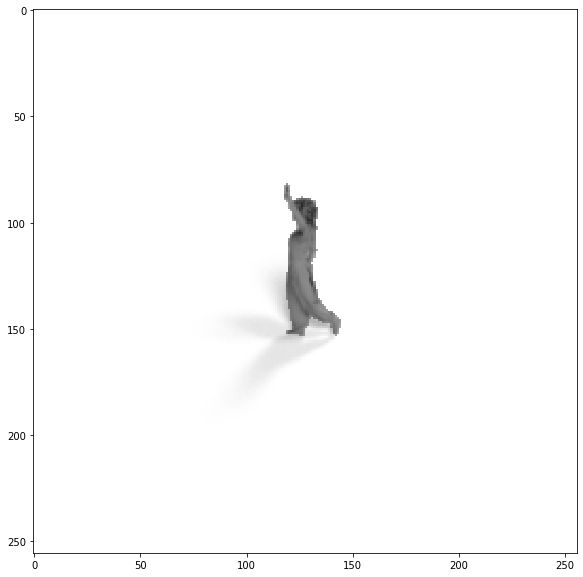

In [22]:
def composite_shadow(mask_np, mitsuba_final_np, mitsuba_shadow_np):
    masked_area = np.where(mask_np != 0)
    
    ret = np.copy(mitsuba_shadow_np)
    ret[masked_area] = mitsuba_final_np[masked_area]
    return ret

composite_np = composite_shadow(mask_np, mitsuab_final_np, mitsuba_shadow_np)
show(composite_np)

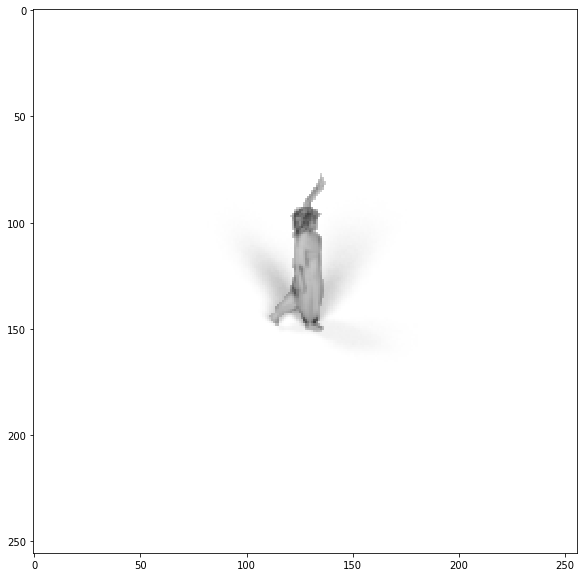

In [23]:
test_img = '/home/ysheng/Documents/vis_pattern/imgs/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Walking_A/pattern/num_23_size_0.1_ibl/composite.png'
test_np = imageio.imread(test_img)
show(test_np)

In [ ]:
testing_ibl = '/home/ysheng/Dataset/ibls/real/20050806-03_hd.hdr'
ibl_img = cv2.imread(testing_ibl)
show(ibl_img)

ori = '/home/ysheng/Dataset/ibls/real/hdr/20050806-03_hd.hdr'
ori_ibl_img = cv2.imread(ori)
show(ori_ibl_img)

In [ ]:
test_predict = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_A/real/20070310-05_hd/predict.png'
test_predict_np = cv2.imread(test_predict)
show(test_predict_np)

In [ ]:
test_predict_out = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/real/20050806-03_hd/predict.png.npy'
test_gt_out = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/real/20050806-03_hd/gt.png.npy'

test_predict_np,test_gt_np = np.load(test_predict_out), np.load(test_gt_out)
print(np.max(test_predict_np))
print(np.max(test_gt_np))

show(test_predict_np)
show(test_gt_np)


print('loss: {}'.format(np.linalg.norm(test_gt_np-test_predict_np, 2)))

In [ ]:
test_predict_out = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_48_size_0.07_ibl/predict.png.npy'
test_gt_out = '/home/ysheng/Dataset/evaluation/simulated_combine_female_short_outfits_audrey_blair_summertimefull_CDIG8Female_StandH/pattern/num_48_size_0.07_ibl/gt.png.npy'

test_predict_np,test_gt_np = np.load(test_predict_out), np.load(test_gt_out)
print(np.max(test_predict_np))
print(np.max(test_gt_np))

show(test_predict_np)
show(test_gt_np)


print('loss: {}'.format(np.linalg.norm(test_gt_np-test_predict_np, 2)))